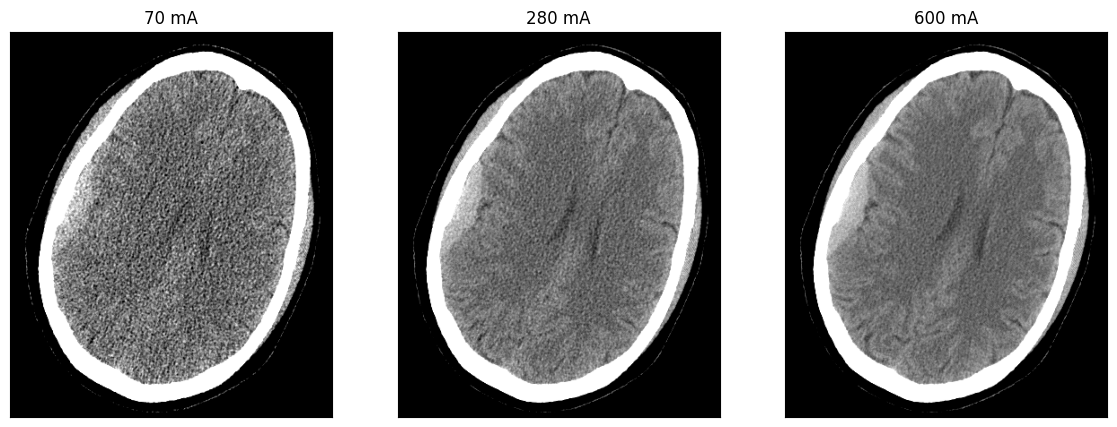

In [16]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

dicom_dir = '/home/jayse.weaver/temp_images/mA_variation/'

files = ['case_179_varymA_70_count500_30_5mm.dcm', 
            'case_179_varymA_280_count500_30_5mm.dcm',
            'case_179_varymA_600_count500_30_5mm.dcm']

rows=1
cols=3

fig, axs = plt.subplots(nrows=rows, ncols=cols, gridspec_kw=dict(wspace=0, hspace=0.2), figsize=(5*cols, 5*rows))
axs = axs.flat
for ax, file in zip(axs, files):
    ds = pydicom.dcmread(dicom_dir + file)
    img = ds.pixel_array + ds.RescaleIntercept

    ax.imshow(img[55:485, 65:425], vmin=0, vmax=80, cmap='gray') # show img
    ax.set_title(file.split('_')[3] + ' mA')
    ax.set_xticks([])
    ax.set_yticks([])

Text(0.5, 0, 'False Positive Rate')

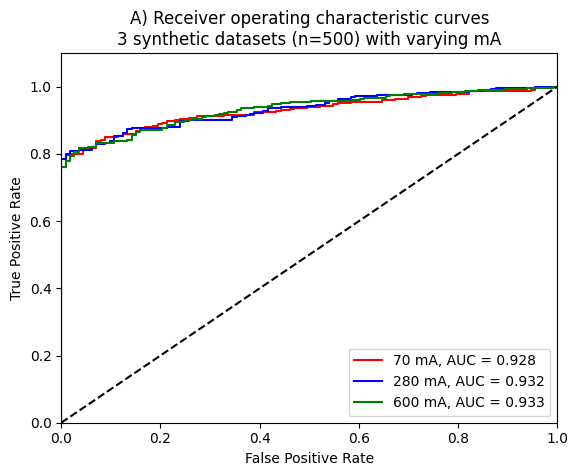

In [17]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# read in Hssayeni results
df = pd.read_csv('../datasets/real_dataset_predictions.csv')

results_real = df[["Any_ICH", "Model_Output"]].to_numpy()
results_real = results_real[~np.isnan(results_real).any(axis=1), :] # remove rows with nan (no CT images)

labels_real = results_real[:, 0]
pred_real = results_real[:, 1]

fpr_real, tpr_real, thresholds_real = metrics.roc_curve(labels_real, pred_real, pos_label=1)
roc_df_real = pd.DataFrame(zip(fpr_real, tpr_real, thresholds_real),columns = ["FPR","TPR","Threshold"])

roc_auc = metrics.auc(fpr_real, tpr_real)

#dataset_path = Path('../datasets')
dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/'
dataset_names = ['varymA_70_count500', 'varymA_280_count500', 'varymA_600_count500']
mA_values = ['70 mA', '280 mA', '600 mA']
#dataset_names = ['mA_280_run1', 'mA_280_run2', 'mA_280_run3', 'mA_280_standard_run1', 'mA_280_standard_run2', 'mA_280_standard_run3']
colors = ['red', 'blue', 'green'] #, 'blue', 'green', 'c']
styles = ['-', '-', '-'] #, '-.', '-.', '-.']

auc = []
for idx, dataset in enumerate(dataset_names):

    # read in synthetic results
    ds1 = pd.read_csv(dataset_path + dataset + '/' + dataset + '_results.csv')
    fpr, tpr, thresh = metrics.roc_curve(ds1['truth'], ds1['pred'], pos_label=1)
    auc.append(metrics.auc(fpr, tpr))

    roc_df = pd.DataFrame(zip(fpr, tpr, thresh),columns = ["FPR","TPR","Threshold"])
    roc_df.to_csv(mA_values[idx] + '.csv')

    plt.plot(fpr, tpr, styles[idx], label = (mA_values[idx] + ', AUC = %0.3f' % auc[idx]), color=colors[idx], markersize=5)

plt.title('A) Receiver operating characteristic curves\n3 synthetic datasets (n=500) with varying mA')
#plt.plot(fpr_real, tpr_real, '--', label = 'Real AUC = %0.3f' % roc_auc, color='red', markersize=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


<Figure size 640x480 with 0 Axes>

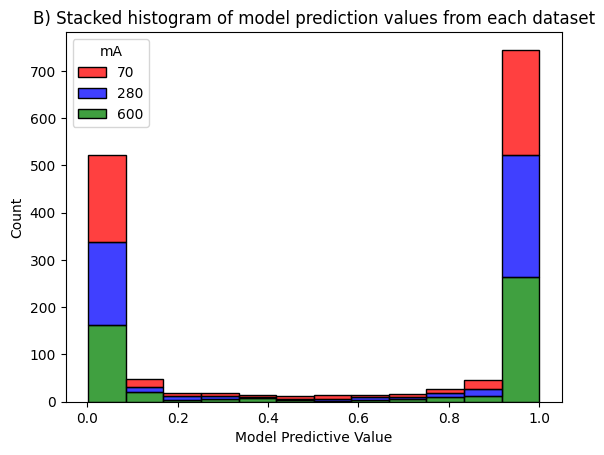

<Figure size 640x480 with 0 Axes>

In [18]:
# plot histogram of predicted value from each dataset
import seaborn as sns

mA70 = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/varymA_70_count500/varymA_70_count500_results.csv')
mA280 = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/varymA_280_count500/varymA_280_count500_results.csv')
mA600 = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/varymA_600_count500/varymA_600_count500_results.csv')

mA70['mA'] = 70
mA280['mA'] = 280
mA600['mA'] = 600

all_preds = pd.concat([mA70, mA280, mA600]).reset_index()

#print(all_preds.to_string())

#plt.figure(figsize=(10,10))
sns.histplot(data=all_preds, x="pred", hue="mA", multiple="stack", palette=['red', 'blue', 'green'])
plt.title('B) Stacked histogram of model prediction values from each dataset')
plt.xlabel('Model Predictive Value')

plt.figure()
#sns.lineplot()

# TODO: bin all_preds by volume size into new dataframes, run scikit AUC 

Text(0.5, 0, 'False Positive Rate')

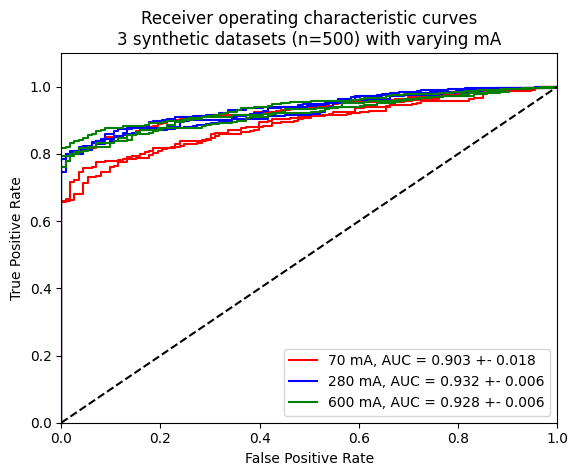

In [22]:
# same ROC as above cells but w/ 3 models per mA level

#dataset_path = Path('../datasets')
dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/'
dataset_names = ['varymA_70_count500', 'varymA_280_count500', 'varymA_600_count500']
model_names = ['CAD_1', 'CAD_2', 'CAD_3']
mA_values = ['70 mA', '280 mA', '600 mA']
colors = ['red', 'blue', 'green']
styles = ['-', '-', '-']

for idx, dataset in enumerate(dataset_names):
    auc = []
    for idx1, model in enumerate(model_names):
        # read in synthetic results
        ds1 = pd.read_csv(dataset_path + dataset + '/' + dataset + '_' + model + '_results.csv')
        fpr, tpr, thresh = metrics.roc_curve(ds1['truth'], ds1['pred'], pos_label=1)
        auc.append(metrics.auc(fpr, tpr))

        roc_df = pd.DataFrame(zip(fpr, tpr, thresh),columns = ["FPR","TPR","Threshold"])
        roc_df.to_csv(mA_values[idx] + '.csv')

        if idx1==2:
            plt.plot(fpr, tpr, styles[idx], label = (mA_values[idx] + ', AUC = %0.3f +- %0.3f' % (np.mean(auc), np.std(auc))), color=colors[idx], markersize=0)
        else:
            plt.plot(fpr, tpr, styles[idx], color=colors[idx], markersize=5)

plt.title('Receiver operating characteristic curves\n3 synthetic datasets (n=500) with varying mA')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

varymA_70_count500
[np.float64(0.9284717934645903), np.float64(0.8945141890192312), np.float64(0.8858018339393107)]
varymA_280_count500
[np.float64(0.9323591959936885), np.float64(0.9385561729665455), np.float64(0.925018865335803)]
varymA_600_count500
[np.float64(0.9331138094258077), np.float64(0.920193912784981), np.float64(0.9309414374242527)]
[np.float64(0.9029292721410441), np.float64(0.931978078098679), np.float64(0.9280830532116804)]
[np.float64(0.018408178969007503), np.float64(0.005533149350943027), np.float64(0.0056485220800030584)]


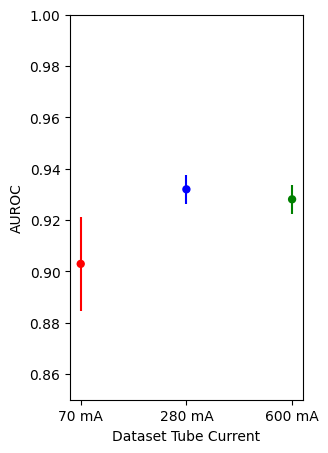

In [59]:
# same ROC as above cells but w/ 3 models per mA level

#dataset_path = Path('../datasets')
dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/'
dataset_names = ['varymA_70_count500', 'varymA_280_count500', 'varymA_600_count500']
model_names = ['CAD_1', 'CAD_2', 'CAD_3']
mA_values = ['70 mA', '280 mA', '600 mA']
colors = ['red', 'blue', 'green']
styles = ['-', '-', '-']

auc_mean = []
auc_std = []
for idx, dataset in enumerate(dataset_names):
    auc = []
    for idx1, model in enumerate(model_names):
        # read in synthetic results
        ds1 = pd.read_csv(dataset_path + dataset + '/' + dataset + '_' + model + '_results.csv')
        fpr, tpr, thresh = metrics.roc_curve(ds1['truth'], ds1['pred'], pos_label=1)
        auc.append(metrics.auc(fpr, tpr))

        roc_df = pd.DataFrame(zip(fpr, tpr, thresh),columns = ["FPR","TPR","Threshold"])
        roc_df.to_csv(mA_values[idx] + '.csv')

        if idx1==2:
            auc_mean.append(np.mean(auc))
            auc_std.append(np.std(auc))

        # if idx1==2:
        #     plt.plot(fpr, tpr, styles[idx], label = (mA_values[idx] + ', AUC = %0.3f +- %0.3f' % (np.mean(auc), np.std(auc))), color=colors[idx], markersize=0)
        # else:
        #     plt.plot(fpr, tpr, styles[idx], color=colors[idx], markersize=5)
    print(dataset)
    print(auc)

print(auc_mean)
print(auc_std)

plt.figure(figsize=(3,5))
#plt.title('Mean AUROC of 3 synthetic\ndatasets (n=500) with varying mA\n')
plt.ylabel('AUROC')
plt.xlabel('Dataset Tube Current')
plt.scatter(mA_values, auc_mean, linewidth=0, color=colors)
plt.errorbar(mA_values, auc_mean, fmt=' ', yerr=auc_std, ecolor=colors)
plt.ylim([0.85, 1])
plt.show()


# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'--', color='black')
# plt.xlim([0, 1])
# plt.ylim([0, 1.1])
